# Effects of sample size on classification performance

A demo which analyzes how the classification performance is affected by varying samples sizes.
Cohorts are created at different samples sizes using the _generate_spectra_ function and cross-validated upon to calculate the area under the ROC curve of the classification.
The Sci-kit learn package is used for the machine learning analysis.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from spectral_generator import generate_spectra

## Loading input data 

Spectral data is used for calibrating the model. Data from the lung cancer vs. non-symptomatic controls is used for this demo. Water measurement are loaded in as well to calculate the measurement noise.

### Blood serum spectra

In [2]:
serum_spectra = pd.read_csv('data/dataset_1.csv') # load the cancer and non-cancer spectra from file

In [3]:
X = serum_spectra.iloc[0:100000, 1:] # matrix containing the spectra of lung cancer and control samples. samples in rows, wavenumers in columns.
X.columns = X.columns.astype(float)

y = serum_spectra.iloc[0:100000, 0] # vector containing the sample labels.
y = y.replace({'lung cancer control': 0, 'lung cancer case': 1})

### Water spectra

In [4]:
water_spectra = pd.read_csv('data/dataset_2.csv') # load the mean-subtracted water spectra from file.
water_spectra.columns = water_spectra.columns.astype(float)

## Defining the calibration parameters

Parameters are calculated from the input data and will be given as inputs to the _spectral_generator_ function.

### Calculating the biological properties

In [5]:
mu_neg = X[y==0].mean(axis=0) # mean spectrum of control samples
mu_pos = X[y==1].mean(axis=0) # mean spectrum of case samples

B_neg = X[y==0] - mu_neg # calibration vectors for control samples
B_pos = X[y==1] - mu_pos # calibration vectors for case samples

d = mu_pos - mu_neg # discriminant vector, defining the difference in mean between cases and controls

### Calculating the measurement noise

In [6]:
epsilon_std = water_spectra.std(axis=0) # standard deviation across the spectral features of the water measurements
epsilon_std *= 9.15 # scaling factor, to account for the l2 vector normalization in the preprocessing of the sera measurements

## Classification pipeline

An L2-regularized logistic regression binary classifier is used.
Model performance is estimated in a 10 fold cross-validation on standardized features.
The regularization strength of the logistic regression is tuned in an inner 3 fold cross-validation on each training split of the outer cross-validation.

In [7]:
cv_3  = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

clf = LogisticRegression(penalty='l2', tol=1e-2, max_iter=100000)

pipeline = Pipeline([('scale', StandardScaler(with_mean=True, with_std=True)),
                     ('clf', clf)])

estimator = GridSearchCV(estimator=pipeline, 
                         param_grid={'clf__C': 2. ** np.arange(-12, 15, 3)},
                         cv=cv_3, scoring='roc_auc', n_jobs=1, 
                         error_score='raise', verbose=0)

## Effects of sample size 

A set of different sample sizes is tested. Multiple cohorts are generated for each sample size. Classification performance is then assessed in a 10-fold cross-validation on each generated cohort of a given sample size. A classification model is fit and the area under the ROC curve (ROC-AUC) gets calculated for each cross-validation split. ROC-AUC values are then averaged across all folds for a given sample size.

In [8]:
# set the sample sizes to test for. 
# balanced cases and controls will be selected for each size.
sample_sizes = [20, 100, 200, 400, 800, 1600]

# set the number of times to repeat the cross-validation using each sample size.
# different cohorts will be created in each repetition.
# the higher the number, the more robust the classification performance estimation is (especially for smaller sample sizes).
n_repeats = 5

In [9]:
results = [] # list to store the classification result of each sample size.
random_state = 0 # random state to be incremented such that each generated cohort is based on a different random seed.

for sample_size in sample_sizes:
    start = time.time() # to monitor how much time is taken in each loop iteration.
    print('n=%d' % sample_size, end='\t')
    
    roc_aucs_train = [] # list to store the calculated roc_aucs for the training sets for all repetitions and CV splits.
    roc_aucs_test = [] # list to store the calculated roc_aucs for the testing sets for all repetitions and CV splits.
    for rep in range(n_repeats):
        random_state += 1
        X_gen, y_gen = generate_spectra(B_neg=B_neg, B_pos=B_pos, 
                                        mu_neg=mu_neg, mu_pos=mu_pos, 
                                        n_neg=int(round(sample_size/2)), n_pos=int(round(sample_size/2)), 
                                        beta_std_neg='auto', beta_std_pos='auto', 
                                        epsilon_std=epsilon_std, 
                                        random_state=random_state)
        
        scores = cross_validate(estimator=estimator, 
                                X=X_gen, y=y_gen, # use the generated cohort as the input to the cv.
                                cv=cv_10, 
                                scoring='roc_auc',
                                verbose=0, 
                                n_jobs=-1, # using all cores available to evaluate the cv splits in parallel.
                                return_train_score=True,
                                error_score='raise')
        
        roc_aucs_train.extend(scores['train_score']) # extend
        roc_aucs_test.extend(scores['test_score'])
    
    # append the result for the current sample size.
    results.append({
        'n_samples': sample_size, 
        'cv_roc_auc_mean_train': np.mean(roc_aucs_train),
        'cv_roc_auc_std_train': np.std(roc_aucs_train),
        'cv_roc_auc_mean_test': np.mean(roc_aucs_test),
        'cv_roc_auc_std_test': np.std(roc_aucs_test)
    })
    
    print('roc_auc_train= %.2f ± %.2f' % (results[-1]['cv_roc_auc_mean_train'], results[-1]['cv_roc_auc_std_train']), end=', ')
    print('roc_auc_test=%.2f ± %.2f, elpsd %ds' % (results[-1]['cv_roc_auc_mean_test'], results[-1]['cv_roc_auc_std_test'], int(time.time()-start)))

n=20	roc_auc_train= 0.86 ± 0.11, roc_auc_test=0.48 ± 0.50, elpsd 3s
n=100	roc_auc_train= 0.85 ± 0.09, roc_auc_test=0.72 ± 0.16, elpsd 4s
n=200	roc_auc_train= 0.86 ± 0.08, roc_auc_test=0.77 ± 0.11, elpsd 9s
n=400	roc_auc_train= 0.95 ± 0.05, roc_auc_test=0.80 ± 0.08, elpsd 20s
n=800	roc_auc_train= 0.95 ± 0.01, roc_auc_test=0.84 ± 0.05, elpsd 59s
n=1600	roc_auc_train= 0.94 ± 0.01, roc_auc_test=0.87 ± 0.03, elpsd 277s


## Display results

In [10]:
df_results = pd.DataFrame(results)
display(df_results)

,n_samples,cv_roc_auc_mean_train,cv_roc_auc_std_train,cv_roc_auc_mean_test,cv_roc_auc_std_test
0,20,0.858272,0.109849,0.480000,0.499600
1,100,0.852454,0.087018,0.716000,0.155177
2,200,0.860533,0.084536,0.773800,0.111587
3,400,0.952990,0.048816,0.802950,0.077017
4,800,0.946919,0.010294,0.842988,0.045663
5,1600,0.938949,0.005788,0.870256,0.030975


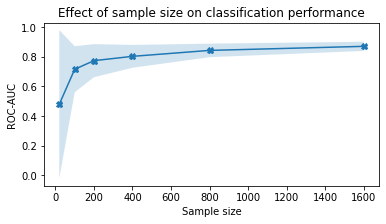

In [11]:
fig = plt.figure(figsize=(6, 3))

plt.title('Effect of sample size on classification performance')
plt.plot(df_results['n_samples'], df_results['cv_roc_auc_mean_test'], marker='X')
plt.fill_between(df_results['n_samples'], 
                 df_results['cv_roc_auc_mean_test']+df_results['cv_roc_auc_std_test'], 
                 df_results['cv_roc_auc_mean_test']-df_results['cv_roc_auc_std_test'],
                 alpha=0.2)
plt.xlabel('Sample size')
plt.ylabel('ROC-AUC')

plt.show()